# TP2: Predicting user conversions - Trocafone 

Based on the traffic over the Trocafone website we will try to estimate if a person will buy in the next 15 days.

## I/ Importation of the librairies and data

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
plt.style.use('ggplot')

### Librairies for implementing xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV   #Perforing grid search

## Libraries for PCA and SVM
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import svm

# To print the tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
### Select only columns important for me
### dtype is because I had some warnings about the type of some columns

df_events = pd.read_csv(r'C:/Users/hugol/Documents/Cours/UBA/Org_Datos/tp2/events_up_to_01062018.csv', dtype = {'sku': float, 'url': str, 'model': str, 11: 'str', 12: 'str', 14: 'str', 15: 'str'}, \
                        usecols=['timestamp', 'event', 'person', 'sku', 'model', 'staticpage', 'campaign_source'] )

df_labels = pd.read_csv(r'C:/Users/hugol/Documents/Cours/UBA/Org_Datos/tp2/labels_training_set.csv')

In [3]:
### Import the person ids of the test data to predict their label
df_person_test = pd.read_csv(r'C:/Users/hugol/Documents/Cours/UBA/Org_Datos/tp2/trocafone_kaggle_test.csv')

## II/ Pre-processing of the data - Feature engineering

In [5]:
## Convert the column timestamp from str to timestamp format
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'])

### Create columns that count the number of events for each person from the beginning

In [6]:
### Create a pivot table by person and event to count the number of event each person have
table = pd.pivot_table(df_events,index=["person","event"], values = 'timestamp', aggfunc = 'count')

# Pivot in the other way to have the count of events as columns
# Put 0 as a value instead of NaN
df = table.unstack(fill_value = 0)
# Withdraw the axis name timestamp
df.columns = df.columns.droplevel(0)

In [7]:
# Show how it looks like
df.head(3)

event,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site
person,,,,,,,,,,,
0008ed71,0,0,3,0,1,0,0,0,0,0,2
00091926,15,25,2,0,0,0,0,0,0,372,34
00091a7a,1,5,0,0,0,0,0,0,0,3,1


### Creation of ratio functions over the different events

In [8]:
# Number of conversion event over viewed product event
def conversion_viewed(row):
    if row['viewed product'] != 0:
        return row['conversion'] / row['viewed product']
    else:
        return 0

# Viewed product over visited site
def viewed_visited(row):
    if row['visited site'] != 0:
        return row['viewed product'] / row['visited site']
    else:
        return 0

# Viewed product over listing    
def viewed_listing(row):
    if row['brand listing'] != 0:
        return row['viewed product'] / row['brand listing']
    else:
        return 0

# Viewed product over ad campaign hit
def viewed_adcampaign(row):
    if row['ad campaign hit'] != 0:
        return row['viewed product'] / row['ad campaign hit']
    else:
        return 0
    

# Conversion over checkout
def conversion_checkout(row):
    if row['checkout'] != 0:
        return row['conversion'] / row['checkout']
    else:
        return 0
    
# % of the most viewed product over the total number of viewed product
def ratio_most_viewed_model(row):
    if row['viewed product_recent'] != 0:
        return row['max_viewed_count'] / row['viewed product_recent']
    else:
        return 0
    
# Sum the counts of different events related to e-commerce
def sum_ecommerce(row):
    return row['FaqEcommerce'] + row['TermsAndConditionsReturnEcommerce'] + row['TermsAndConditionsEcommerce']
    


In [9]:
### Apply the functions above to the data to have some ratios

## See if the person only look or want to buy
df['conversion_viewedproduct'] = df.apply(lambda row: conversion_viewed(row), axis = 1)

##Show the interest of the client
df['viewed_visited'] = df.apply(lambda row: viewed_visited(row), axis = 1)
df['viewed_listing'] = df.apply(lambda row: viewed_listing(row), axis = 1)

##Show if the client respond to ad campaign
df['viewed_campaignhit'] = df.apply(lambda row: viewed_adcampaign(row), axis = 1)

###Show if the client give up a lot during the payment
df['conversion_checkout'] = df.apply(lambda row: conversion_checkout(row), axis = 1)

In [10]:
df.head(3)

event,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,conversion_viewedproduct,viewed_visited,viewed_listing,viewed_campaignhit,conversion_checkout
person,,,,,,,,,,,,,,,,
0008ed71,0,0,3,0,1,0,0,0,0,0,2,0.0,0.000000,0.00,0.0,0.0
00091926,15,25,2,0,0,0,0,0,0,372,34,0.0,10.941176,14.88,24.8,0.0
00091a7a,1,5,0,0,0,0,0,0,0,3,1,0.0,3.000000,0.60,3.0,0.0


### Number of events and ratios only over the last month

<div class = 'alert alert-warning'> It enables to see if there is a change in the client activity: if more traffic than before maybe there are more chances that he will buy. At the opposite, maybe he does not go to the website anymore and we should take it into account. </div>

In [11]:
#Create of the first of may
first_may = pd.to_datetime('2018-05-01')
#Compare each event with this date and only take the more recent ones
df_events_recent = df_events[df_events['timestamp'] > first_may]

### Create a pivot table by person and event to count the number of event each person have
table_recent = pd.pivot_table(df_events_recent,index=["person","event"], values = 'timestamp', aggfunc = 'count')

#Pivot in the other way to have the count of events as columns
#And put 0 as a value instead of NaN
df_recent = table_recent.unstack(fill_value = 0)
df_recent.columns = df_recent.columns.droplevel(0)


## See if the person only look or want to buy
df_recent['conversion_viewedproduct_recent'] = df_recent.apply(lambda row: conversion_viewed(row), axis = 1)

## Show the interest of the client
df_recent['viewed_visited_recent'] = df_recent.apply(lambda row: viewed_visited(row), axis = 1)
df_recent['viewed_listing_recent'] = df_recent.apply(lambda row: viewed_listing(row), axis = 1)

## Show if the client respond to ad campaign
df_recent['viewed_campaignhit_recent'] = df_recent.apply(lambda row: viewed_adcampaign(row), axis = 1)

###Show if the client give up a lot during the payment
df_recent['conversion_checkout_recent'] = df_recent.apply(lambda row: conversion_checkout(row), axis = 1)

In [12]:
df_recent.head(3)

event,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,conversion_viewedproduct_recent,viewed_visited_recent,viewed_listing_recent,viewed_campaignhit_recent,conversion_checkout_recent
person,,,,,,,,,,,,,,,,
0008ed71,0,0,3,0,1,0,0,0,0,0,2,0.000000,0.000000,0.000,0.0,0.000000
00091926,15,25,2,0,0,0,0,0,0,372,34,0.000000,10.941176,14.880,24.8,0.000000
000ba417,1,24,6,1,14,0,1,0,0,153,6,0.006536,25.500000,6.375,153.0,0.166667


In [13]:
### I have two dataframes with datas and we need to merge it
### I did it the left way in case there is person that did not go to the website after the first may
### I add suffixes 'recent' not to mixed up with the columns
df3 = df.merge(df_recent, how = 'left', left_on = 'person', right_on = 'person', suffixes = ('', '_recent'))
# I filled NaN values with 0
df3.fillna(value = 0, inplace = True)

In [14]:
df3.head(3)

event,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,...,search engine hit_recent,searched products_recent,staticpage_recent,viewed product_recent,visited site_recent,conversion_viewedproduct_recent,viewed_visited_recent,viewed_listing_recent,viewed_campaignhit_recent,conversion_checkout_recent
person,,,,,,,,,,,,,,,,,,,,,
0008ed71,0,0,3,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0.00,0.0,0.0
00091926,15,25,2,0,0,0,0,0,0,372,...,0.0,0.0,0.0,372.0,34.0,0.0,10.941176,14.88,24.8,0.0
00091a7a,1,5,0,0,0,0,0,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0


### Count the number of times the person has viewed the model he viewed the most during the last month

In [15]:
### Only take the most recent events
### Group by person and model and then count
df_viewed = df_events_recent[df_events_recent['event'] == 'viewed product'].groupby(['person', 'model'])['timestamp'].count()
df_viewed = df_viewed.unstack()
df_viewed_max = df_viewed.max(axis = 1)

## Get the name of the model that the person viewed the most
## In order to know if he bought it or not
df_viewed_max_name = df_viewed.idxmax(axis = 1)

In [16]:
df_viewed_max.head(3)

person
00091926    94.0
000ba417    28.0
000c79fe     3.0
dtype: float64

In [17]:
### Find the person that bought the most viewed

# Rename the column 
df_viewed_max_name.rename('model', inplace = True)

# Group by person and model the recent event of conversion
df_conversion_pers_mod_recent = df_events_recent[df_events_recent['event'] == 'conversion'][['person', 'model']]
# Merge this dataframe with the dataframe of the name of the most viewed model for each person
df_conversion_max = df_conversion_pers_mod_recent.merge(df_viewed_max_name.to_frame(), left_index=True, right_index=True, \
                                                        how ='inner' , on = 'person')

# Create the dataframe of the person who bought their most viewed model
df_conversion_max = df_conversion_max[df_conversion_max['model_x'] == df_conversion_max['model_y']]

In [18]:
df_conversion_max

,person,model_x,model_y
18205,0a5d63bb,iPhone 5s,iPhone 5s
22751,a8a5a7cb,Samsung Galaxy A5 2017,Samsung Galaxy A5 2017
31441,d56c55c5,Samsung Galaxy J5,Samsung Galaxy J5
33439,acab6e7f,Samsung Galaxy S8,Samsung Galaxy S8


<div class = 'alert alert-warning'> I will not utilize it in my model because the data is too poor: only 4 people did it. </div >

In [19]:
# Merge the number of max viewed with the dataframe of the other columns on feature engineering
# Again I do it the left way not to lose person
df4 = df3.merge(df_viewed_max.to_frame(), left_index=True, right_index=True, how = 'left')

# Rename the column to understand it when I print the dataframe
df4.rename(columns={0:'max_viewed_count'}, inplace=True)
df4.fillna(value = 0, inplace = True)

In [20]:
df4.head(3)

,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,...,searched products_recent,staticpage_recent,viewed product_recent,visited site_recent,conversion_viewedproduct_recent,viewed_visited_recent,viewed_listing_recent,viewed_campaignhit_recent,conversion_checkout_recent,max_viewed_count
person,,,,,,,,,,,,,,,,,,,,,
0008ed71,0,0,3,0,1,0,0,0,0,0,...,0.0,0.0,0.0,2.0,0.0,0.000000,0.00,0.0,0.0,0.0
00091926,15,25,2,0,0,0,0,0,0,372,...,0.0,0.0,372.0,34.0,0.0,10.941176,14.88,24.8,0.0,94.0
00091a7a,1,5,0,0,0,0,0,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0


In [21]:
# Create the ratio of the number of viewed the max model over the number of viewed for all models
df4['ratio_most_viewed_model'] = df4.apply(lambda row: ratio_most_viewed_model(row), axis = 1)

In [22]:
### Show that it works
df4[['ratio_most_viewed_model', 'max_viewed_count', 'viewed product_recent']].head(3)

,ratio_most_viewed_model,max_viewed_count,viewed product_recent
person,,,
0008ed71,0.000000,0.0,0.0
00091926,0.252688,94.0,372.0
00091a7a,0.000000,0.0,0.0


### Count the number of different models a person has viewed recently

In [23]:
# Group by person and count the distinct model for each person
df_different_viewed = df_events_recent[df_events_recent['event'] == 'viewed product'].groupby('person')['model'].nunique()

In [24]:
df_different_viewed.head(3)

person
00091926    36
000ba417    26
000c79fe     1
Name: model, dtype: int64

In [25]:
df4.merge(df_different_viewed.to_frame(), left_index=True, right_index=True, how = 'left')
df4.rename(columns={'model': 'count_different_model'}, inplace=True)

In [26]:
### Rather than getting all the static page, only get the how to sell, how to buy and group faq ecommerce, 
### term and conditions ecommerce and term and conditions return

### Here only for the last month 

# Create a list with the variables that interest me
staticpage_interesting = ['how-to-sell', 'how-to-buy', 'FaqEcommerce', 'TermsAndConditionsReturnEcommerce',
       'TermsAndConditionsEcommerce']

# Only take these elements and count them for each person
df_static = df_events_recent[df_events_recent['staticpage'].isin(staticpage_interesting)].groupby(['person', 'staticpage']).size().unstack(fill_value = 0)
# Sum up all the events related to ecommerce
df_static['ecommerce'] = df_static.apply(lambda x: sum_ecommerce(x), axis = 1)
# Eliminate the columns because we aggregated them in the sum
df_static = df_static.drop(['TermsAndConditionsEcommerce', 'TermsAndConditionsReturnEcommerce', 'FaqEcommerce'], axis = 1)

### Merge with df4
df4 = df4.merge(df_static, left_index=True, right_index=True, how = 'left')
df4.fillna(value = 0, inplace = True)

In [27]:
# Show an ecommerce value above 0
df4[df4['ecommerce'] > 0].head(3)

,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,...,conversion_viewedproduct_recent,viewed_visited_recent,viewed_listing_recent,viewed_campaignhit_recent,conversion_checkout_recent,max_viewed_count,ratio_most_viewed_model,how-to-buy,how-to-sell,ecommerce
person,,,,,,,,,,,,,,,,,,,,,
00546f4c,24,1,13,4,49,1,11,146,6,181,...,0.037037,4.50,0.000000,0.000000,0.25,11.0,0.407407,0.0,0.0,1.0
00fa4cd7,7,5,2,2,5,0,4,25,1,27,...,0.074074,1.35,5.400000,3.857143,1.00,11.0,0.407407,0.0,0.0,1.0
011beb42,44,147,4,1,38,0,63,11,3,124,...,0.013889,2.25,0.742268,2.880000,0.50,17.0,0.236111,0.0,0.0,1.0


In [28]:
## Show that we still have the same number of person with our new dataframe
print(df4['ad campaign hit'].count(), df_events['person'].nunique())

38829 38829


<div class = 'alert alert-warning'> The phase of feature engineering is over. With the new dataframe, composed of 37 columns, we will predict the labels for the person </div>

## III/ Predictions with XGBoost

In [29]:
# Merge the dataframe with the labels
df_events_train = df4.merge(df_labels, how = 'inner', left_on = 'person', right_on = 'person')
df_events_train.head(3)

,person,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,...,viewed_visited_recent,viewed_listing_recent,viewed_campaignhit_recent,conversion_checkout_recent,max_viewed_count,ratio_most_viewed_model,how-to-buy,how-to-sell,ecommerce,label
0,0008ed71,0,0,3,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,000c79fe,1,0,1,0,1,0,1,9,0,...,3.0,0.0,3.0,0.0,3.0,1.0,0.0,0.0,0.0,0
2,001802e4,5,0,1,0,4,0,0,4,0,...,4.0,0.0,0.8,0.0,2.0,0.5,0.0,0.0,0.0,0


In [30]:
# Drop the person column because it is the id of our data
df_events_train.drop(columns = 'person', inplace = True)

# Show some statistics over the different columns I created
df_events_train.describe()

,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,...,viewed_visited_recent,viewed_listing_recent,viewed_campaignhit_recent,conversion_checkout_recent,max_viewed_count,ratio_most_viewed_model,how-to-buy,how-to-sell,ecommerce,label
count,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000,...,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000,19414.000000
mean,4.893273,5.459617,1.676059,0.183579,4.144071,0.022200,2.721181,3.290770,0.291542,32.411301,...,6.376969,4.849898,6.498182,0.067686,10.163696,0.602753,0.005615,0.004069,0.038786,0.050479
std,11.201587,23.697509,2.509280,0.736412,10.482960,0.296395,5.844117,12.179278,1.528046,82.964038,...,9.326469,15.443467,17.695579,0.281656,18.146351,0.332482,0.095860,0.075507,0.315126,0.218937
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,1.200000,0.000000,0.000000,0.000000,2.000000,0.333333,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,10.000000,...,3.333333,0.000000,1.428571,0.000000,5.000000,0.588235,0.000000,0.000000,0.000000,0.000000
75%,5.000000,4.000000,2.000000,0.000000,4.000000,0.000000,3.000000,2.000000,0.000000,29.000000,...,8.000000,3.285714,5.500000,0.000000,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,523.000000,1891.000000,66.000000,30.000000,470.000000,22.000000,245.000000,739.000000,69.000000,2355.000000,...,184.000000,356.000000,628.000000,10.000000,386.000000,1.000000,3.000000,4.000000,14.000000,1.000000


In [31]:
## No need for normalizing in xgboost, it will do it

## Separate labels and datas
X, y = df_events_train.iloc[:,:-1],df_events_train.iloc[:,-1]

## Create a matrix that enable xgboost to do faster
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [32]:
## Split the data in train and test to evaluate our model
X_train, X_test, y_train, y_test = \
       train_test_split(X, y, test_size=0.2, random_state=123)

## I put some basics parameters
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [33]:
## Train the model
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [34]:
## Create a numpy array that predict the label (in terms of probability)
preds = xg_reg.predict(X_test)

In [35]:
# Show preds
preds

array([0.19272882, 0.30734777, 0.17874059, ..., 0.30692947, 0.182241  ,
       0.18385753], dtype=float32)

In [36]:
## Generally we compute with rmse so I did it before realizing in Kaggle we compare with auc
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.259785


In [40]:
## Here I want to do cross-validation
## Indeed with the cv we can have different Xtest and Xtrain and it improves the model

## Implement the parameters
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10, 'n_estimators' : 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, 
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[11:58:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:58:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[

[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_de

[11:58:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[11:58:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[11:58:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[11:58:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4


<div class = 'alert alert-warning'> Show the different trees that xgboost create. </div>

In [41]:
## In cv results we have the mean and std both on the different train and test datas
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.459278,0.000372,0.459285,0.000203
1,0.423601,0.000451,0.423622,0.000789
2,0.392328,0.000527,0.392407,0.001410
3,0.364865,0.000758,0.365019,0.001721
4,0.341457,0.001044,0.341620,0.002185


In [42]:
## The last line correspond to the best tree with the lower rmse on test data
new_rmse = float(cv_results["test-rmse-mean"].tail(1).values)
print('new rmse = %f  ; old rmse = %f' % (new_rmse, rmse))

new rmse = 0.206343  ; old rmse = 0.259785


<div class = 'alert alert-warning'> The cross validation is useful because we test over all the datas and then compute the mean. Before we only had one sample and it could be harder to guess the label or easier than for the average cross validation. </div>

In [43]:
xg_reg2 = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[11:58:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:58:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:58:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[11:58:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[11:58:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[11:58:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:58:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[11:58:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[11:58:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4


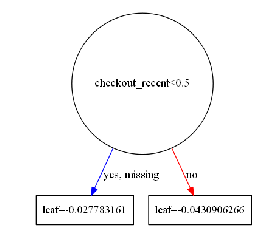

In [44]:
## Plot the tree
xgb.plot_tree(xg_reg2, num_trees=1)
plt.show()

<div class = 'alert alert-warning'> This function is nice because it enables to plot the tree to understand what the important features in the algorithm are. However here I do not understand why it does not plot all the tree. I do not think it could be the only node in the tree ... </div>

<div class = 'alert alert-info'> I realized I used rmse because it is the most common but in Kaggle we are evaluated with auc. Thus from now on I will only use the auc function. It makes sense because our data is not equally reparted. In the describe before we saw we have 0,95 of 0 (the majority of people do not buy). </div>

In [45]:
# The same as before but with the auc function
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="auc", as_pandas=True, seed=123)

[11:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[11:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[11:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[11:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[11:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[

[11:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[11:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[11:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[11:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[11:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[11:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[11:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[11:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[11:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

In [46]:
cv_results.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.756652,0.008067,0.757305,0.014983
1,0.757771,0.007698,0.758437,0.015655
2,0.758312,0.007654,0.757579,0.015086
3,0.759337,0.008957,0.757993,0.014503
4,0.759337,0.008957,0.757993,0.014503


In [47]:
print("AUC measure : ", float((cv_results["test-auc-mean"]).tail(1).values))

AUC measure :  0.853831


<div class = 'alert alert-warning'> Here we got an AUC measure which does not look bad. We will try to optimize the parameters of the algorithm in order to improve the score. </div>

In [48]:
# Here I created a function that is hugely inspired by: 
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# It enables to fit the model and predict it.
# What it does more is to predict the feature importances and print the accuracy of the model

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print( "\nModel Report")
    print( "Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print( "AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    
    ## different than on the website: it is get_booster and not booster
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

<div class = 'alert alert-warning'> Elige n_estimators = 100 porque con mas arboles mi computadora toma mucho mas tiempo. </div>

C:\Users\hugol\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9535
AUC Score (Train): 0.890966


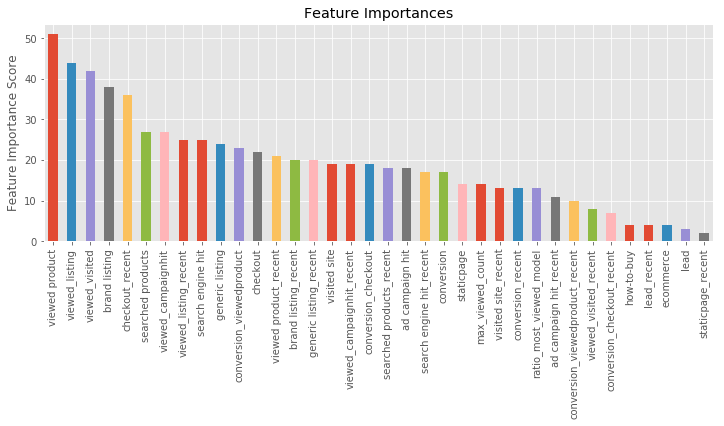

In [49]:
#Pick all the columns
predictors = [x for x in X.columns]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X, predictors)

<div class = 'alert alert-warning'> Here we have the importance score of each feature for the algorithm. It is very interesting because it helps to see what part of the feature engineering are important and which are not. Here the two main importants are the ratio viewed product over brand listing and the count of viewed product. <br>
At the opposite, how to buy, sell and ecommerce or lead does not have much impact on the data. I believe it is because these events are rare and thus do not discriminate enough the datas. </div>

In [71]:
# As said in the guide for optimizing parameters for xgboost, I begin with max depth and min child weight
# Max depth is the max depth of the tree
# Min child weight is the minimum size of a child to be split again

param_test1 = {
 'max_depth':np.arange(3,8,2),
 'min_child_weight':np.arange(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, gamma=0, subsample=0.9, colsample_bytree=0.9,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X,y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.84744, std: 0.00760, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.84450, std: 0.00774, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.84718, std: 0.00910, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.83609, std: 0.00903, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.83326, std: 0.00466, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.83110, std: 0.00390, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.80745, std: 0.00952, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.81093, std: 0.00268, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.81690, std: 0.01116, params: {'max_depth': 7, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1},
 0.8474364280434854)

In [72]:
## We try to improve the model: take the two best values of max_depth and min_child_weight
## But this time we have a path of 1 instead of 2

param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=100, gamma=0, subsample=0.9, colsample_bytree=0.9,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X,y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.84901, std: 0.00725, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.84773, std: 0.00772, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.84744, std: 0.00760, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.84740, std: 0.00804, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.84190, std: 0.00706, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.84333, std: 0.00672, params: {'max_depth': 4, 'min_child_weight': 2}],
 {'max_depth': 2, 'min_child_weight': 1},
 0.8490130208858216)

In [73]:
###Tune gamma
# Gamma specifies the minimum loss reduction required to make a split in the tree
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
### We put the new best values for max_depth and min_child
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=2,
 min_child_weight=1, subsample=0.9, colsample_bytree=0.9,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X, y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

###We already had the best value for gamma: 0.0

([mean: 0.84901, std: 0.00725, params: {'gamma': 0.0},
  mean: 0.84868, std: 0.00757, params: {'gamma': 0.1},
  mean: 0.84901, std: 0.00734, params: {'gamma': 0.2},
  mean: 0.84932, std: 0.00748, params: {'gamma': 0.3},
  mean: 0.84927, std: 0.00771, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 0.8493170125280006)

In [74]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=2,
 min_child_weight= 1, gamma=0.3, objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X, y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.85190, std: 0.00686, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.85151, std: 0.00832, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.85153, std: 0.00769, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.85176, std: 0.00765, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.85087, std: 0.00765, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.85147, std: 0.00759, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.85205, std: 0.00715, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.85180, std: 0.00743, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.85265, std: 0.00870, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.85224, std: 0.00752, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.85212, std: 0.00778, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.85156, std: 0.00769, params: {'colsample_bytree': 0.8, 'subsample'

C:\Users\hugol\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9506
AUC Score (Train): 0.867578


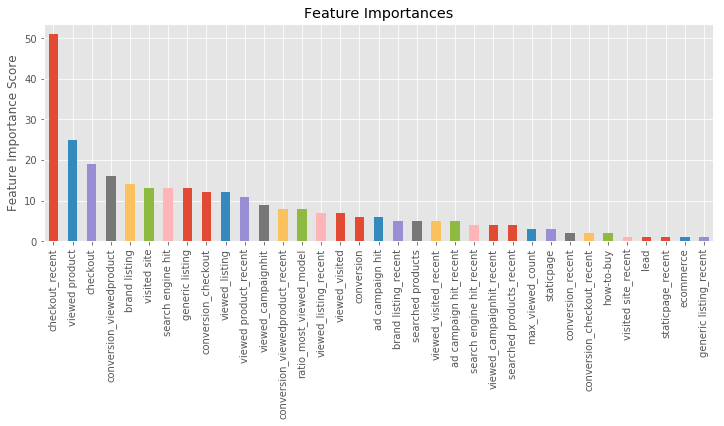

In [50]:
### Recalibrate
#predictors = [x for x in X.columns]
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=2,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.6,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, X, predictors)

### I do not understand why the AUC Score is lower ...

<div class = 'alert alert-warning'> I do not understand why my AUC score does not improve here. However it improves on the kaggle competition which is the objective. I believe it is because here it has overfit before and this algorithm overfit less. </div>

<div class = 'alert alert-warning'> It impresses me to see that changing a bit the parameters change a lot the feature importances. Checkout recent was the 5th before and right now it is the first and by far. In general the first stay the first and the last stay the last but among them there are big changes. Here it does not impress me that it takes into account checkout_recent because this is one of the criterias I would have used a lot too. </div>

## IV/ SVM

In [75]:
## Normalize the datas before doing the PCA

x = df_events_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalize = pd.DataFrame(x_scaled)

In [76]:
# Make an instance of the Model
# Here I decide to keep 95% if the information
pca = PCA(.95)

## Separate labels and datas
X, y = df_normalize.iloc[:,:-1],df_events_train.iloc[:,-1]

## Split the data in train and test to evaluate our model
X_train, X_test, y_train, y_test = \
       train_test_split(X, y, test_size=0.2, random_state=123)

In [77]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [78]:
explained_variance = pca.explained_variance_ratio_  

In [79]:
## It shows the importance of the column of the datas after the pca
explained_variance

array([0.77012405, 0.07265687, 0.03756605, 0.01645807, 0.01348176,
       0.01144417, 0.00955554, 0.00825356, 0.00750921, 0.00624637])

<div class = 'alert alert-warning'> 77% of the datas can be represented in only one column and more than 90% in three columns. It always impressed me. </div>

In [80]:
## Apply the pca to the datas
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [82]:
## Trying with the poly kernel 
clf = svm.SVC(kernel='poly', class_weight={0: 0.05, 1: 0.95 })
cross_val_score(clf, X, y, scoring='roc_auc', cv=3) 

array([0.65284598, 0.65371638, 0.64974383])

In [83]:
## Trying with the linear kernel 

clf = svm.SVC(kernel='rbf', class_weight={0: 0.05, 1: 0.95 })
cross_val_score(clf, X, y, scoring='roc_auc', cv=3) 

array([0.66186477, 0.66197451, 0.65910954])

In [84]:
## Trying with the linear kernel 

clf = svm.SVC(kernel='linear', class_weight={0: 0.05, 1: 0.95 })
cross_val_score(clf, X, y, scoring='roc_auc', cv=3) 

array([0.68184571, 0.68640201, 0.67548943])

<div class = 'alert alert-warning'> After some attempts I put a class_weight of 0.05/0.95 and I test the different kernels. I got the best result for the linear (with AUC computation) so this is the one I will use and try to optimize some parameters with it. </div>

In [85]:
## Create the linear kernel with C = 1000

clf = svm.SVC(kernel='linear', class_weight={0: 0.050479, 1: 0.940521}, C = 1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [86]:
print('AUC Score', metrics.roc_auc_score(y_test, y_pred))

AUC Score 0.6592498000487824


<div class = 'alert alert-warning'> I realized after that I could have put balanced and got the same result. I did not think about it because at first I thought I should put balanced if my data is balanced and not the opposite. </div>

In [87]:
## Create the linear kernel with C = 1000
#http://localhost:8888/notebooks/tp2_orgdatos.ipynb#
clf = svm.SVC(kernel='linear', class_weight='balanced', C = 1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [88]:
print('AUC Score', metrics.roc_auc_score(y_test, y_pred))

AUC Score 0.6592498000487824


<div class = 'alert alert-warning'> I read that the other important parameter is C so I decided to try different values of C. I realized that the AUC score improves when C is higher. However it does not increase a lot (0,02 win from C = 1 to C = 1000). Thus I will not pursue to utilize the svm for my datas. Maybe it good work good if I improve better the parameters but from right now I am far from the results I got with the XGBoost. </div>

## V/ Transform to csv

In [51]:
# Show once again how the dataframe of the transformed data looks like
df4.head(3)

,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,...,conversion_viewedproduct_recent,viewed_visited_recent,viewed_listing_recent,viewed_campaignhit_recent,conversion_checkout_recent,max_viewed_count,ratio_most_viewed_model,how-to-buy,how-to-sell,ecommerce
person,,,,,,,,,,,,,,,,,,,,,
0008ed71,0,0,3,0,1,0,0,0,0,0,...,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
00091926,15,25,2,0,0,0,0,0,0,372,...,0.0,10.941176,14.88,24.8,0.0,94.0,0.252688,0.0,0.0,0.0
00091a7a,1,5,0,0,0,0,0,0,0,3,...,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [52]:
# Merge the person to guess with the feature engineering dataframe
# Here the goal is to order the feature engineering dataframe the same way the dataframe associated with the excel is
# We should submit then the excel with the person and the corresponding label
df_test = df_person_test.merge(df4, how = 'inner', left_on = 'person', right_on ='person')
df_test.head(3)
df_test.drop(columns = 'person', inplace = True)

In [53]:
df_test.head(3)

,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,...,conversion_viewedproduct_recent,viewed_visited_recent,viewed_listing_recent,viewed_campaignhit_recent,conversion_checkout_recent,max_viewed_count,ratio_most_viewed_model,how-to-buy,how-to-sell,ecommerce
0,0,0,1,0,1,0,1,1,0,4,...,0.0,4.000000,0.0,0.0,0.0,4.0,1.000000,0.0,0.0,0.0
1,29,4,7,0,21,1,0,6,0,404,...,0.0,4.586207,0.0,26.6,0.0,78.0,0.586466,0.0,0.0,0.0
2,1,5,1,0,1,0,2,1,0,13,...,0.0,6.500000,2.6,13.0,0.0,6.0,0.461538,0.0,0.0,0.0


In [54]:
## Create the function to transform the array of prediction to the desired form of submit
def transform_to_csv(preds_test):
    
    df_person_test_copy = df_person_test.copy()
    
    # We add the label to the dataframe of the person
    # As we order it before it is ordered the same in the two dataframe
    df_person_test_copy['label'] = pd.DataFrame(data=preds_test)
    
    # Transform in the csv
    df_person_test_copy.to_csv('results4.csv', index = False)

In [55]:
# Create an array of the prediction based on xgboost 1st tentative with r-mean
preds_test = xg_reg.predict(df_test)

In [56]:
transform_to_csv(preds_test)

In [66]:
# Create an array of the prediction based on xgboost with modelfit before optimization
preds_test1 = xgb1.predict_proba(df_test)

In [67]:
# Create an array of the prediction based on xgboost classifier after optimizing
preds_test2 = xgb2.predict_proba(df_test)

In [68]:
# Show how the results look like:
# The first column if the probability for the label 0 and second one for the label 1
preds_test2

array([[0.9905458 , 0.00945417],
       [0.95921975, 0.04078024],
       [0.98408794, 0.01591207],
       ...,
       [0.8934754 , 0.10652456],
       [0.8934754 , 0.10652456],
       [0.8934754 , 0.10652456]], dtype=float32)

In [69]:
# Create a function for xgb classifier in order to only have the probability for label 1
def preds_proba(preds2):
    preds_proba_1 = []
    for i in range(len(preds2)):
        preds_proba_1.append(preds2[i][1])
    return preds_proba_1

In [70]:
transform_to_csv(preds_proba(preds_test2))